In [108]:
from subgrounds.subgrounds import Subgrounds
from subgrounds.subgraph import SyntheticField
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

sg = Subgrounds()
messari_maple = sg.load_subgraph("https://api.thegraph.com/subgraphs/name/papercliplabs/messari-maple-finance")
official_maple = sg.load_subgraph("https://api.thegraph.com/subgraphs/name/maplefinance/maple")

checks = {}
MATCH_PERCENT_TOLERANCE = 0.00001 # Much be within 0.001% of eachother

ACTUAL_ETH_PRICE = 1

In [109]:
# Helpers
def listItemsMatch(a: list, b: list) -> list:
    exact_match = (a == b)
    within_tolerance = abs(1 - a / b) < MATCH_PERCENT_TOLERANCE
    return exact_match | within_tolerance 

def tokenAmountToUSD(amount: int, decimals: int, tokenPriceUSD: float) -> float:
    return amount / (10**decimals) * tokenPriceUSD 
    


In [110]:
# Commonly used field paths
protocols = messari_maple.Query.lendingProtocols
markets = messari_maple.Query.markets

tokenAmountToUSD = lambda tokenAmount, decimals, tokenPriceUSD: tokenAmount / (10**decimals) * tokenPriceUSD 

# Synthetic fields
messari_maple.Market.cumulativeInterestCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._cumulativeInterest, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativePoolDelegateRevenueCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._cumulativePoolDelegateRevenue, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativeTreasuryRevenueCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._cumulativeTreasuryRevenue, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativeDepositCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._cumulativeDeposit, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativeBorrowCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._cumulativeBorrow, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativeLiquidateCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._cumulativeLiquidate, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativeStakeLockerInterestCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._stakeLocker.cumulativeInterestInPoolInputTokens, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativeProtocolSideRevenueCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._cumulativeTreasuryRevenue, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativeSupplySideRevenueCurrentValueUSD = SyntheticField(
        lambda a, b: a + b,
        SyntheticField.FLOAT,
        [messari_maple.Market.cumulativeStakeLockerInterestCurrentValueUSD, messari_maple.Market.cumulativeInterestCurrentValueUSD]
    )

messari_maple.Market.cumulativeTotalRevenueCurrentValueUSD = SyntheticField(
        lambda a, b: a + b ,
        SyntheticField.STRING,
        [messari_maple.Market.cumulativeSupplySideRevenueCurrentValueUSD, messari_maple.Market.cumulativeProtocolSideRevenueCurrentValueUSD]
    )


In [111]:
# Get ETH price for convience elsewhere

ethToken = messari_maple.Query.token(id="0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2")

ethPriceUSD = sg.query([
    ethToken.lastPriceUSD
])

print(ethPriceUSD)

1217.03


In [112]:
# Check total accounts equals protocol accounts
accounts = messari_maple.Query.accounts(first=10000)

cumulativeUniqueUsers = sg.query([
    protocols.cumulativeUniqueUsers
])

numAccounts = len(sg.query([accounts.id]))

officialSubgraphAccounts = len(sg.query([
    official_maple.Query.accounts(first=10000).id
]))

result = (numAccounts == cumulativeUniqueUsers and cumulativeUniqueUsers == officialSubgraphAccounts )
print(f"numAccounts: {numAccounts}, cumulativeUniqueUsers: {cumulativeUniqueUsers}, numAccountsInOfficial: {officialSubgraphAccounts}, result: {result}")

checks["unique_users_self_consistant"] = result

numAccounts: 1196, cumulativeUniqueUsers: 1196, numAccountsInOfficial: 1499, result: False


In [113]:
# Compare treasury fees with official

ethTotals = official_maple.Query.totals(where=[official_maple.Total.symbol=="WETH"])
usdcTotals = official_maple.Query.totals(where=[official_maple.Total.symbol=="USDC"])

officialEthTotals = sg.query_df([
    ethTotals.treasuryFees,
    ethTotals.currentLoaned,
    ethTotals.interestEarned,
    ethTotals.liquidityProvided,
    ethTotals.loanOriginations,
]).sum(axis=0)
# keys = officialEthTotals.keys() 
officialEthTotals = officialEthTotals / (10**18) * ethPriceUSD

officialUSDCTotals = np.array(sg.query([
    usdcTotals.treasuryFees,
    usdcTotals.currentLoaned,
    usdcTotals.interestEarned,
    usdcTotals.liquidityProvided,
    usdcTotals.loanOriginations,
]))
officialUSDCTotals = officialUSDCTotals / (10**6)

officalTotalsUSD = officialUSDCTotals + officialEthTotals.to_numpy()

print(officalTotalsUSD)
print(officialUSDCTotals)

summaryDf = pd.DataFrame({"officialEthTotals": officialEthTotals, "officialUSDCTotals": officialUSDCTotals, "officalTotalsUSD": officalTotalsUSD})

summaryDf.to_csv("exports/officialTotals.csv")
summaryDf


[3555243.2409242876 630243641.3400021 31038400.5623303 663482194.2174939
 1399664860.12]
[3.44000848e+06 5.97167200e+08 3.07412101e+07 6.30398772e+08
 1.35901119e+09]


,officialEthTotals,officialUSDCTotals,officalTotalsUSD
totals_treasuryFees,115234.762299,3.440008e+06,3555243.240924
totals_currentLoaned,33076441.34,5.971672e+08,630243641.340002
totals_interestEarned,297190.473536,3.074121e+07,31038400.56233
totals_liquidityProvided,33083421.767001,6.303988e+08,663482194.217494
totals_loanOriginations,40653670.12,1.359011e+09,1399664860.12


In [114]:

protocolVals = sg.query([
    protocols.totalValueLockedUSD,
    protocols.cumulativeSupplySideRevenueUSD,
    protocols.cumulativeProtocolSideRevenueUSD,
    protocols.cumulativeTotalRevenueUSD,
    protocols.totalDepositBalanceUSD,
    protocols.cumulativeDepositUSD,
    protocols.totalBorrowBalanceUSD,
    protocols.cumulativeBorrowUSD,
    protocols.cumulativeLiquidateUSD
])

marketSums = sg.query_df([
    markets.totalValueLockedUSD,
    markets._cumulativeSupplySideRevenueUSD,
    markets._cumulativeProtocolSideRevenueUSD,
    markets._cumulativeTotalRevenueUSD,
    markets.totalDepositBalanceUSD,
    markets.cumulativeDepositUSD,
    markets.totalBorrowBalanceUSD,
    markets.cumulativeBorrowUSD,
    markets.cumulativeLiquidateUSD,
]).sum(axis=0)

results = listItemsMatch(marketSums.array.to_numpy(), protocolVals)
compareDf = pd.DataFrame({"market cumulatives": marketSums, "protocol values": protocolVals, "result": results})

print(type(compareDf))

checks["market_cumulatives_match"] = results.all()

compareDf

<class 'pandas.core.frame.DataFrame'>


/var/folders/q3/3f7l37mx6xxgf9mq9l_t26f00000gn/T/ipykernel_79993/1564354813.py:4: RuntimeWarning: invalid value encountered in divide
  within_tolerance = abs(1 - a / b) < MATCH_PERCENT_TOLERANCE


,market cumulatives,protocol values,result
markets_totalValueLockedUSD,6.865871e+08,6.865871e+08,True
markets__cumulativeSupplySideRevenueUSD,3.911867e+07,3.911867e+07,True
markets__cumulativeProtocolSideRevenueUSD,7.331062e+06,7.331062e+06,True
markets__cumulativeTotalRevenueUSD,4.644973e+07,4.644973e+07,True
markets_totalDepositBalanceUSD,6.622495e+08,6.622495e+08,True
markets_cumulativeDepositUSD,1.186335e+09,1.186335e+09,True
markets_totalBorrowBalanceUSD,6.290109e+08,6.290109e+08,True
markets_cumulativeBorrowUSD,1.452832e+09,1.452832e+09,True
markets_cumulativeLiquidateUSD,0.000000e+00,0.000000e+00,True


In [115]:




marketTokenCumulative = sg.query_df([
    markets.id,
    markets.cumulativeSupplySideRevenueCurrentValueUSD,
    markets.cumulativeProtocolSideRevenueCurrentValueUSD,
    markets.cumulativeTotalRevenueCurrentValueUSD,
    markets.cumulativeDepositCurrentValueUSD,
    markets.cumulativeBorrowCurrentValueUSD,
    markets.cumulativeLiquidateCurrentValueUSD,
    markets.cumulativeInterestCurrentValueUSD,
    markets.cumulativePoolDelegateRevenueCurrentValueUSD,
    markets.cumulativeTreasuryRevenueCurrentValueUSD,
    markets.cumulativeStakeLockerInterestCurrentValueUSD,
])



marketTokenCumulative.to_csv("exports/cumulativeCurrentValueUSD.csv")

marketTokenCumulative


,markets_id,markets_cumulativeSupplySideRevenueCurrentValueUSD,markets_cumulativeProtocolSideRevenueCurrentValueUSD,markets_cumulativeTotalRevenueCurrentValueUSD,markets_cumulativeDepositCurrentValueUSD,markets_cumulativeBorrowCurrentValueUSD,markets_cumulativeLiquidateCurrentValueUSD,markets_cumulativeInterestCurrentValueUSD,markets_cumulativePoolDelegateRevenueCurrentValueUSD,markets_cumulativeTreasuryRevenueCurrentValueUSD,markets_cumulativeStakeLockerInterestCurrentValueUSD
0,0x1a066b0109545455bc771e49e6edef6303cb0a93,1.766958e+05,1.488392e+05,3.255350e+05,2.359667e+07,2.264771e+07,0.0,1.570629e+05,1.963286e+04,1.488392e+05,1.963286e+04
1,0x3e701d29fcb8747b5c3f88649397d88fff9bd3e9,4.325238e+06,1.674692e+06,5.999931e+06,1.930107e+08,2.882608e+08,0.0,4.108976e+06,1.366250e+05,1.674692e+06,2.162619e+05
2,0x6f6c8013f639979c84b756c7fc1500eb5af18dc4,1.126192e+07,2.369260e+06,1.363118e+07,4.081587e+08,4.757500e+08,0.0,1.001059e+07,1.759699e+06,2.369260e+06,1.251324e+06
3,0xa1fe1b5fc23c2dab0c28d4cc09021014f30be8f1,1.271880e+05,1.074070e+05,2.345950e+05,1.635087e+07,1.634327e+07,0.0,1.271880e+05,0.000000e+00,1.074070e+05,0.000000e+00
4,0xd618d93676762a8e3107554d9adbff7dfd7fbf47,3.210411e+06,2.534463e+05,3.463857e+06,5.000000e+07,8.500000e+07,0.0,3.100507e+06,1.875000e+05,2.534463e+05,1.099041e+05
5,0xfebd6f15df3b73dc4307b1d7e65d46413e710c27,1.521128e+07,2.462292e+06,1.767357e+07,4.475778e+08,5.180004e+08,0.0,1.352113e+07,2.382642e+06,2.462292e+06,1.690142e+06


In [116]:

# Convience queries
protocolDf = sg.query_df([
    protocols
    ])

protocolDf = protocolDf.transpose()
protocolDf

protocolDf.to_csv("exports/protocolDf.csv")


Text(0.5, 1.0, 'USDC treasury fees USD (current value)')

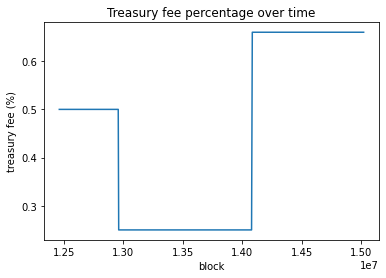

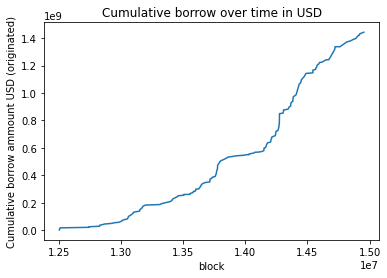

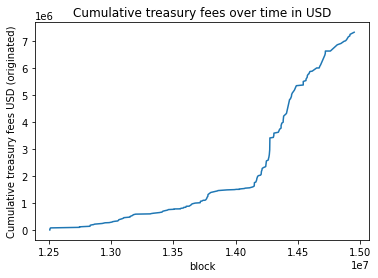

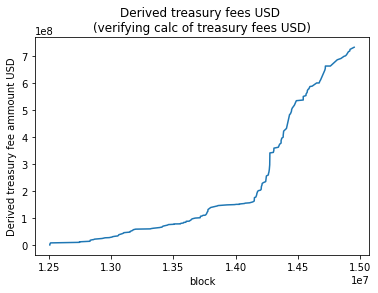

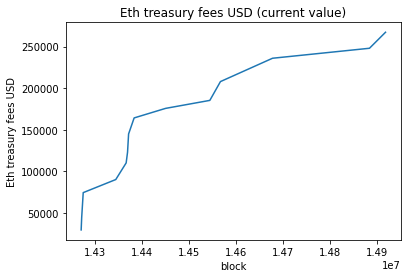

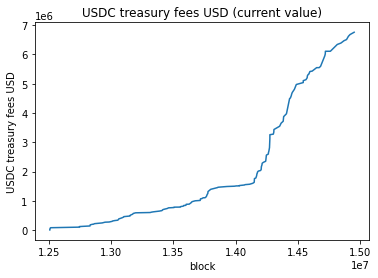

In [117]:
# Treasury fee discrepency analysis

financialSnapshots = messari_maple.Query.financialsDailySnapshots(first=1000000, orderBy=messari_maple.FinancialsDailySnapshot.blockNumber)
borrows = messari_maple.Query.borrows(first=1000000, orderBy=messari_maple.Borrow.blockNumber)

(treasuryFeeBlocks, treasuryFees) = sg.query([
    financialSnapshots.blockNumber,
    financialSnapshots._treasuryFee,
])

treasuryFeePercentages = np.array(treasuryFees) * 100

plt.plot(treasuryFeeBlocks, treasuryFeePercentages)
plt.xlabel("block")
plt.ylabel("treasury fee (%)")
plt.title("Treasury fee percentage over time")

(borrowBlocks, treasuryFeesPaid, treasuryFeesPaidUSD, borrowAmountUSD, symbol) = sg.query([
   borrows.blockNumber,
   borrows._treasuryFeePaid,
   borrows._treasuryFeePaidUSD,
   borrows.amountUSD,
   borrows.asset.symbol
])

interpolatedTreasuryFees = np.interp(borrowBlocks,treasuryFeeBlocks,treasuryFeePercentages)
# plt.figure()
# plt.plot(borrowBlocks,interpolatedTreasuryFees)
# plt.xlabel("block")
# plt.ylabel("interpolated treasury fee (%)")
# plt.title("Interpolated treasury fee percentage over time")

plt.figure()
plt.plot(borrowBlocks, np.cumsum(borrowAmountUSD))
plt.xlabel("block")
plt.ylabel("Cumulative borrow ammount USD (originated)")
plt.title("Cumulative borrow over time in USD")

plt.figure()
plt.plot(borrowBlocks, np.cumsum(treasuryFeesPaidUSD))
plt.xlabel("block")
plt.ylabel("Cumulative treasury fees USD (originated)")
plt.title("Cumulative treasury fees over time in USD")

derivedTreasuryFeesUSD = np.array(borrowAmountUSD) * np.array(interpolatedTreasuryFees)
plt.figure()
plt.plot(borrowBlocks, np.cumsum(derivedTreasuryFeesUSD))
plt.xlabel("block")
plt.ylabel("Derived treasury fee ammount USD")
plt.title("Derived treasury fees USD \n(verifying calc of treasury fees USD)")


# ethBorrowsBase = messari_maple.Query.borrows(where=[messari_maple.Borrow.decimals==12])
# usdcBorrowsBase = messari_maple.Query.borrows(first=1000000, orderBy=messari_maple.Borrow.blockNumber, where=[messari_maple.Borrow.asset.name=="USDC"])

# (ethBorrowBlocks, ethTreasuryFeesPaid) = sg.query([
#     ethBorrowsBase.blockNumber,
#     ethBorrowsBase._treasuryFeePaid,
# ])


ethTokenToUSD = 1 / (10**18) * ethPriceUSD
usdcTokenToUSD = 1 / (10**6) 

ethIndicies = np.where(np.array(symbol) == 'WETH')
ethBlocks = np.array(borrowBlocks)[ethIndicies] 
ethTreasuryFeesPaid = np.array(treasuryFeesPaid)[ethIndicies]
ethTreasuryFeesPaidUSD = ethTreasuryFeesPaid * ethTokenToUSD 

plt.figure()
plt.plot(ethBlocks, np.cumsum(ethTreasuryFeesPaidUSD))
plt.xlabel("block")
plt.ylabel("Eth treasury fees USD")
plt.title("Eth treasury fees USD (current value)")


usdcIndicies = np.where(np.array(symbol) == "USDC")
usdcBlocks = np.array(borrowBlocks)[usdcIndicies] 
usdcTreasuryFeesPaid = np.array(treasuryFeesPaid)[usdcIndicies]
usdcTreasuryFeesPaidUSD = usdcTreasuryFeesPaid * usdcTokenToUSD 

plt.figure()
plt.plot(usdcBlocks, np.cumsum(usdcTreasuryFeesPaidUSD))
plt.xlabel("block")
plt.ylabel("USDC treasury fees USD")
plt.title("USDC treasury fees USD (current value)")





In [118]:
# Report results

print(checks)

{'unique_users_self_consistant': False, 'market_cumulatives_match': True}
